## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-8, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        x = Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1),
                               kernel_regularizer=l1_l2(l1_l2_ratio))(x)
        x = BatchNormalization()(x)
        x = Dropout(drp_ratio)(x)
    
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-4
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [1, 5, 9]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("re_fac:%.2f, re_pat:%i" % (reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________________________

49/49 [==============================] - 1s 21ms/step - loss: 4.4898 - accuracy: 0.6010 - val_loss: 4.5699 - val_accuracy: 0.5450
Epoch 38/50
49/49 [==============================] - 1s 21ms/step - loss: 4.3506 - accuracy: 0.6038 - val_loss: 4.4412 - val_accuracy: 0.5475
Epoch 39/50
49/49 [==============================] - 1s 21ms/step - loss: 4.2134 - accuracy: 0.6095 - val_loss: 4.3124 - val_accuracy: 0.5514
Epoch 40/50
49/49 [==============================] - 1s 21ms/step - loss: 4.0807 - accuracy: 0.6132 - val_loss: 4.2028 - val_accuracy: 0.5474
Epoch 41/50
49/49 [==============================] - 1s 21ms/step - loss: 3.9535 - accuracy: 0.6213 - val_loss: 4.0867 - val_accuracy: 0.5500
Epoch 42/50
49/49 [==============================] - 1s 21ms/step - loss: 3.8357 - accuracy: 0.6218 - val_loss: 3.9769 - val_accuracy: 0.5503
Epoch 43/50
49/49 [==============================] - 1s 21ms/step - loss: 3.7141 - accuracy: 0.6288 - val_loss: 3.8784 - val_accuracy: 0.5503
Epoch 44/50
49/49 

49/49 [==============================] - 1s 21ms/step - loss: 7.1534 - accuracy: 0.5225 - val_loss: 7.0553 - val_accuracy: 0.5109
Epoch 24/50
49/49 [==============================] - 1s 21ms/step - loss: 6.9142 - accuracy: 0.5256 - val_loss: 6.8275 - val_accuracy: 0.5171
Epoch 25/50
49/49 [==============================] - 1s 21ms/step - loss: 6.6821 - accuracy: 0.5326 - val_loss: 6.6117 - val_accuracy: 0.5200
Epoch 26/50
49/49 [==============================] - 1s 21ms/step - loss: 6.4632 - accuracy: 0.5362 - val_loss: 6.4024 - val_accuracy: 0.5217
Epoch 27/50
49/49 [==============================] - 1s 21ms/step - loss: 6.2476 - accuracy: 0.5431 - val_loss: 6.1950 - val_accuracy: 0.5241
Epoch 28/50
49/49 [==============================] - 1s 21ms/step - loss: 6.0418 - accuracy: 0.5504 - val_loss: 6.0047 - val_accuracy: 0.5259
Epoch 29/50
49/49 [==============================] - 1s 21ms/step - loss: 5.8418 - accuracy: 0.5563 - val_loss: 5.8180 - val_accuracy: 0.5278
Epoch 30/50
49/49 

49/49 [==============================] - 1s 21ms/step - loss: 11.6940 - accuracy: 0.4367 - val_loss: 11.4262 - val_accuracy: 0.4554
Epoch 10/50
49/49 [==============================] - 1s 21ms/step - loss: 11.2755 - accuracy: 0.4436 - val_loss: 11.0206 - val_accuracy: 0.4680
Epoch 11/50
49/49 [==============================] - 1s 21ms/step - loss: 10.8786 - accuracy: 0.4529 - val_loss: 10.6295 - val_accuracy: 0.4722
Epoch 12/50
49/49 [==============================] - 1s 21ms/step - loss: 10.4896 - accuracy: 0.4611 - val_loss: 10.2572 - val_accuracy: 0.4809
Epoch 13/50
49/49 [==============================] - 1s 21ms/step - loss: 10.1254 - accuracy: 0.4660 - val_loss: 9.9043 - val_accuracy: 0.4846
Epoch 14/50
49/49 [==============================] - 1s 21ms/step - loss: 9.7700 - accuracy: 0.4761 - val_loss: 9.5603 - val_accuracy: 0.4911
Epoch 15/50
49/49 [==============================] - 1s 21ms/step - loss: 9.4263 - accuracy: 0.4860 - val_loss: 9.2363 - val_accuracy: 0.4936
Epoch 16/

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3896 - accuracy: 0.2022 - val_loss: 15.6647 - val_accuracy: 0.2416
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3829 - accuracy: 0.3082 - val_loss: 15.0479 - val_accuracy: 0.2866
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7182 - accuracy: 0.3479 - val_loss: 14.4542 - val_accuracy: 0.3252
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1453 - accuracy: 0.3664 - val_loss: 13.8849 - val_accuracy: 0.3522
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.6000 - accuracy: 0.3879 - val_loss: 13.3419 - val_accuracy: 0.3795
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0944 - accuracy: 0.4029 - val_loss: 12.8204 - val_accuracy: 0.4072
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6166 - accuracy: 0.4145 - val_loss: 12.3312 - val_accuracy: 0.4316

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.3070 - accuracy: 0.2152 - val_loss: 15.6570 - val_accuracy: 0.2297
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 15.3565 - accuracy: 0.3155 - val_loss: 15.0323 - val_accuracy: 0.2881
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 14.7074 - accuracy: 0.3456 - val_loss: 14.4358 - val_accuracy: 0.3189
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 14.1385 - accuracy: 0.3675 - val_loss: 13.8723 - val_accuracy: 0.3488
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 13.6078 - accuracy: 0.3818 - val_loss: 13.3262 - val_accuracy: 0.3786
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 13.0986 - accuracy: 0.3999 - val_loss: 12.8084 - val_accuracy: 0.4087
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 12.6170 - accuracy: 0.4092 - val_loss: 12.3201 - val_accuracy: 0.4275

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 16.2963 - accuracy: 0.2186 - val_loss: 15.6767 - val_accuracy: 0.2121
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3542 - accuracy: 0.3117 - val_loss: 15.0451 - val_accuracy: 0.2730
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6976 - accuracy: 0.3532 - val_loss: 14.4543 - val_accuracy: 0.3017
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1236 - accuracy: 0.3706 - val_loss: 13.8834 - val_accuracy: 0.3434
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5851 - accuracy: 0.3899 - val_loss: 13.3346 - val_accuracy: 0.3768
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0811 - accuracy: 0.4017 - val_loss: 12.8117 - val_accuracy: 0.4021
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6024 - accuracy: 0.4131 - val_loss: 12.3259 - val_accuracy: 0.4233

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3499 - accuracy: 0.2129 - val_loss: 15.7292 - val_accuracy: 0.2031
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3696 - accuracy: 0.3107 - val_loss: 15.0642 - val_accuracy: 0.2891
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7165 - accuracy: 0.3463 - val_loss: 14.4450 - val_accuracy: 0.3306
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1365 - accuracy: 0.3690 - val_loss: 13.8771 - val_accuracy: 0.3589
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5996 - accuracy: 0.3873 - val_loss: 13.3341 - val_accuracy: 0.3864
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0915 - accuracy: 0.4010 - val_loss: 12.8204 - val_accuracy: 0.4080
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6184 - accuracy: 0.4117 - val_loss: 12.3282 - val_accuracy: 0.4339

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3204 - accuracy: 0.2092 - val_loss: 15.7267 - val_accuracy: 0.1824
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3611 - accuracy: 0.3101 - val_loss: 15.0735 - val_accuracy: 0.2620
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6979 - accuracy: 0.3458 - val_loss: 14.4732 - val_accuracy: 0.2976
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1157 - accuracy: 0.3723 - val_loss: 13.9085 - val_accuracy: 0.3288
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5813 - accuracy: 0.3867 - val_loss: 13.3496 - val_accuracy: 0.3654
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0726 - accuracy: 0.3991 - val_loss: 12.8209 - val_accuracy: 0.3976
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5924 - accuracy: 0.4175 - val_loss: 12.3282 - val_accuracy: 0.4225

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.2898 - accuracy: 0.2146 - val_loss: 15.6674 - val_accuracy: 0.2088
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3380 - accuracy: 0.3173 - val_loss: 15.0163 - val_accuracy: 0.2845
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6958 - accuracy: 0.3490 - val_loss: 14.4250 - val_accuracy: 0.3261
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1216 - accuracy: 0.3672 - val_loss: 13.8644 - val_accuracy: 0.3570
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5872 - accuracy: 0.3875 - val_loss: 13.3150 - val_accuracy: 0.3872
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0794 - accuracy: 0.3987 - val_loss: 12.7962 - val_accuracy: 0.4141
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5978 - accuracy: 0.4151 - val_loss: 12.3067 - val_accuracy: 0.4368

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.2959 - accuracy: 0.2101 - val_loss: 15.6744 - val_accuracy: 0.1916
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3303 - accuracy: 0.3084 - val_loss: 15.0418 - val_accuracy: 0.2764
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6826 - accuracy: 0.3455 - val_loss: 14.4389 - val_accuracy: 0.3145
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.0958 - accuracy: 0.3700 - val_loss: 13.8633 - val_accuracy: 0.3479
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 13.5632 - accuracy: 0.3858 - val_loss: 13.3204 - val_accuracy: 0.3783
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0550 - accuracy: 0.4017 - val_loss: 12.8001 - val_accuracy: 0.4037
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5727 - accuracy: 0.4183 - val_loss: 12.3099 - val_accuracy: 0.4260

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3324 - accuracy: 0.2069 - val_loss: 15.6676 - val_accuracy: 0.2266
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3609 - accuracy: 0.3080 - val_loss: 15.0374 - val_accuracy: 0.2770
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7041 - accuracy: 0.3468 - val_loss: 14.4555 - val_accuracy: 0.3056
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1255 - accuracy: 0.3663 - val_loss: 13.8875 - val_accuracy: 0.3452
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5920 - accuracy: 0.3857 - val_loss: 13.3386 - val_accuracy: 0.3794
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0836 - accuracy: 0.4014 - val_loss: 12.8183 - val_accuracy: 0.4066
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6037 - accuracy: 0.4150 - val_loss: 12.3294 - val_accuracy: 0.4312

Epoch 1/50
49/49 [==============================] - 1s 30ms/step - loss: 16.3418 - accuracy: 0.2133 - val_loss: 15.6945 - val_accuracy: 0.2150
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 15.3565 - accuracy: 0.3152 - val_loss: 15.0454 - val_accuracy: 0.2811
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 14.6917 - accuracy: 0.3541 - val_loss: 14.4412 - val_accuracy: 0.3217
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 14.1152 - accuracy: 0.3733 - val_loss: 13.8753 - val_accuracy: 0.3469
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 13.5851 - accuracy: 0.3874 - val_loss: 13.3217 - val_accuracy: 0.3808
Epoch 6/50
49/49 [==============================] - 1s 23ms/step - loss: 13.0790 - accuracy: 0.4036 - val_loss: 12.8048 - val_accuracy: 0.4079
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 12.5982 - accuracy: 0.4151 - val_loss: 12.3126 - val_accuracy: 0.4313

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3140 - accuracy: 0.2136 - val_loss: 15.7098 - val_accuracy: 0.2144
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 15.3643 - accuracy: 0.3168 - val_loss: 15.0729 - val_accuracy: 0.2662
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7167 - accuracy: 0.3484 - val_loss: 14.4752 - val_accuracy: 0.3034
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1353 - accuracy: 0.3707 - val_loss: 13.9135 - val_accuracy: 0.3349
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.6012 - accuracy: 0.3863 - val_loss: 13.3642 - val_accuracy: 0.3753
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0965 - accuracy: 0.3990 - val_loss: 12.8361 - val_accuracy: 0.4034
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6130 - accuracy: 0.4147 - val_loss: 12.3442 - val_accuracy: 0.4256

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 16.3499 - accuracy: 0.2040 - val_loss: 15.6912 - val_accuracy: 0.2135
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3519 - accuracy: 0.3103 - val_loss: 15.0628 - val_accuracy: 0.2730
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6945 - accuracy: 0.3462 - val_loss: 14.4715 - val_accuracy: 0.3037
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1253 - accuracy: 0.3650 - val_loss: 13.8966 - val_accuracy: 0.3424
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5791 - accuracy: 0.3870 - val_loss: 13.3406 - val_accuracy: 0.3772
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0766 - accuracy: 0.4024 - val_loss: 12.8162 - val_accuracy: 0.4079
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5944 - accuracy: 0.4141 - val_loss: 12.3196 - val_accuracy: 0.4313

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.2660 - accuracy: 0.2177 - val_loss: 15.6719 - val_accuracy: 0.2011
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3395 - accuracy: 0.3156 - val_loss: 14.9913 - val_accuracy: 0.3065
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6910 - accuracy: 0.3490 - val_loss: 14.4073 - val_accuracy: 0.3328
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1116 - accuracy: 0.3740 - val_loss: 13.8430 - val_accuracy: 0.3603
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5697 - accuracy: 0.3916 - val_loss: 13.3061 - val_accuracy: 0.3878
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0677 - accuracy: 0.4056 - val_loss: 12.7836 - val_accuracy: 0.4156
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5910 - accuracy: 0.4123 - val_loss: 12.2956 - val_accuracy: 0.4352

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.3855 - accuracy: 0.2071 - val_loss: 15.6912 - val_accuracy: 0.2166
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3672 - accuracy: 0.3091 - val_loss: 15.0376 - val_accuracy: 0.2870
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7247 - accuracy: 0.3441 - val_loss: 14.4438 - val_accuracy: 0.3247
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1444 - accuracy: 0.3637 - val_loss: 13.8760 - val_accuracy: 0.3544
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.6057 - accuracy: 0.3865 - val_loss: 13.3262 - val_accuracy: 0.3820
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.1057 - accuracy: 0.3963 - val_loss: 12.8150 - val_accuracy: 0.4093
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6278 - accuracy: 0.4100 - val_loss: 12.3259 - val_accuracy: 0.4295

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.2699 - accuracy: 0.2171 - val_loss: 15.6766 - val_accuracy: 0.2221
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3319 - accuracy: 0.3134 - val_loss: 15.0433 - val_accuracy: 0.2841
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.6826 - accuracy: 0.3487 - val_loss: 14.4441 - val_accuracy: 0.3132
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1101 - accuracy: 0.3703 - val_loss: 13.8731 - val_accuracy: 0.3514
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5722 - accuracy: 0.3897 - val_loss: 13.3228 - val_accuracy: 0.3874
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0663 - accuracy: 0.4013 - val_loss: 12.7993 - val_accuracy: 0.4126
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5894 - accuracy: 0.4142 - val_loss: 12.3084 - val_accuracy: 0.4350

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 16.2881 - accuracy: 0.2153 - val_loss: 15.6728 - val_accuracy: 0.2057
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3538 - accuracy: 0.3124 - val_loss: 15.0336 - val_accuracy: 0.2873
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 14.7011 - accuracy: 0.3476 - val_loss: 14.4421 - val_accuracy: 0.3215
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1146 - accuracy: 0.3729 - val_loss: 13.8702 - val_accuracy: 0.3505
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.5854 - accuracy: 0.3872 - val_loss: 13.3199 - val_accuracy: 0.3848
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0765 - accuracy: 0.4058 - val_loss: 12.7949 - val_accuracy: 0.4127
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.5910 - accuracy: 0.4169 - val_loss: 12.3025 - val_accuracy: 0.4365

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 16.3303 - accuracy: 0.2132 - val_loss: 15.6969 - val_accuracy: 0.2094
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 15.3728 - accuracy: 0.3079 - val_loss: 15.0691 - val_accuracy: 0.2804
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 14.7032 - accuracy: 0.3493 - val_loss: 14.4802 - val_accuracy: 0.3057
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 14.1395 - accuracy: 0.3694 - val_loss: 13.9007 - val_accuracy: 0.3434
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 13.6026 - accuracy: 0.3845 - val_loss: 13.3547 - val_accuracy: 0.3756
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 13.0947 - accuracy: 0.4002 - val_loss: 12.8378 - val_accuracy: 0.4016
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 12.6154 - accuracy: 0.4137 - val_loss: 12.3437 - val_accuracy: 0.4281

Epoch 1/50
49/49 [==============================] - 1s 25ms/step - loss: 16.2974 - accuracy: 0.2121 - val_loss: 15.6896 - val_accuracy: 0.1905
Epoch 2/50
49/49 [==============================] - 1s 19ms/step - loss: 15.3553 - accuracy: 0.3141 - val_loss: 15.0545 - val_accuracy: 0.2551
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 14.7038 - accuracy: 0.3427 - val_loss: 14.4405 - val_accuracy: 0.3146
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 14.1227 - accuracy: 0.3687 - val_loss: 13.8647 - val_accuracy: 0.3502
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 13.5858 - accuracy: 0.3859 - val_loss: 13.3155 - val_accuracy: 0.3814
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 13.0852 - accuracy: 0.3970 - val_loss: 12.7959 - val_accuracy: 0.4129
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 12.6061 - accuracy: 0.4106 - val_loss: 12.3123 - val_accuracy: 0.4333

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.2704 - accuracy: 0.2123 - val_loss: 15.7057 - val_accuracy: 0.2098
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 15.3327 - accuracy: 0.3199 - val_loss: 15.0811 - val_accuracy: 0.2776
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 14.6929 - accuracy: 0.3502 - val_loss: 14.4931 - val_accuracy: 0.3082
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 14.1167 - accuracy: 0.3725 - val_loss: 13.9181 - val_accuracy: 0.3387
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 13.5801 - accuracy: 0.3876 - val_loss: 13.3681 - val_accuracy: 0.3689
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 13.0713 - accuracy: 0.4051 - val_loss: 12.8389 - val_accuracy: 0.4021
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 12.5959 - accuracy: 0.4155 - val_loss: 12.3422 - val_accuracy: 0.4216

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 11.3533 - accuracy: 0.3257 - val_loss: 6.8758 - val_accuracy: 0.3189
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 4.7353 - accuracy: 0.3997 - val_loss: 3.8505 - val_accuracy: 0.3235
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 2.9729 - accuracy: 0.4280 - val_loss: 3.0017 - val_accuracy: 0.2938
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 2.3561 - accuracy: 0.4465 - val_loss: 2.5800 - val_accuracy: 0.3331
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 2.0752 - accuracy: 0.4531 - val_loss: 2.3053 - val_accuracy: 0.3926
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 1.9192 - accuracy: 0.4666 - val_loss: 2.1603 - val_accuracy: 0.3995
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 1.8534 - accuracy: 0.4731 - val_loss: 2.0404 - val_accuracy: 0.4379
Epoch 8/50
4

49/49 [==============================] - 1s 20ms/step - loss: 16.9880 - accuracy: 0.1076 - val_loss: 16.6034 - val_accuracy: 0.1144
Epoch 41/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9977 - accuracy: 0.1094 - val_loss: 16.6034 - val_accuracy: 0.1142
Epoch 42/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9974 - accuracy: 0.1093 - val_loss: 16.6035 - val_accuracy: 0.1142
Epoch 43/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9954 - accuracy: 0.1096 - val_loss: 16.6032 - val_accuracy: 0.1142
Epoch 44/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9857 - accuracy: 0.1118 - val_loss: 16.6032 - val_accuracy: 0.1144
Epoch 45/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9973 - accuracy: 0.1089 - val_loss: 16.6031 - val_accuracy: 0.1146
Epoch 46/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0057 - accuracy: 0.1073 - val_loss: 16.6027 - val_accuracy: 0.1145
Epoc

49/49 [==============================] - 1s 20ms/step - loss: 17.1113 - accuracy: 0.1006 - val_loss: 16.7182 - val_accuracy: 0.0950
Epoch 34/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1103 - accuracy: 0.1018 - val_loss: 16.7182 - val_accuracy: 0.0951
Epoch 35/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1216 - accuracy: 0.1002 - val_loss: 16.7184 - val_accuracy: 0.0949
Epoch 36/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1206 - accuracy: 0.1009 - val_loss: 16.7182 - val_accuracy: 0.0948
Epoch 37/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1099 - accuracy: 0.1020 - val_loss: 16.7181 - val_accuracy: 0.0948
Epoch 38/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1149 - accuracy: 0.1015 - val_loss: 16.7183 - val_accuracy: 0.0945
Epoch 39/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1133 - accuracy: 0.1003 - val_loss: 16.7183 - val_accuracy: 0.0945
Epoc

Epoch 26/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9908 - accuracy: 0.1093 - val_loss: 16.6032 - val_accuracy: 0.1181
Epoch 27/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9972 - accuracy: 0.1088 - val_loss: 16.6032 - val_accuracy: 0.1179
Epoch 28/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0027 - accuracy: 0.1119 - val_loss: 16.6030 - val_accuracy: 0.1182
Epoch 29/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9987 - accuracy: 0.1106 - val_loss: 16.6030 - val_accuracy: 0.1182
Epoch 30/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9977 - accuracy: 0.1117 - val_loss: 16.6030 - val_accuracy: 0.1179
Epoch 31/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9951 - accuracy: 0.1113 - val_loss: 16.6031 - val_accuracy: 0.1179
Epoch 32/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9862 - accuracy: 0.1126 - val_loss: 16.6035 - val_accuracy:

Epoch 19/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1423 - accuracy: 0.0915 - val_loss: 16.7382 - val_accuracy: 0.0967
Epoch 20/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1404 - accuracy: 0.0952 - val_loss: 16.7385 - val_accuracy: 0.0965
Epoch 21/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1319 - accuracy: 0.0944 - val_loss: 16.7385 - val_accuracy: 0.0964
Epoch 22/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1305 - accuracy: 0.0949 - val_loss: 16.7384 - val_accuracy: 0.0968
Epoch 23/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1308 - accuracy: 0.0932 - val_loss: 16.7386 - val_accuracy: 0.0966
Epoch 24/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1302 - accuracy: 0.0951 - val_loss: 16.7387 - val_accuracy: 0.0963
Epoch 25/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1327 - accuracy: 0.0955 - val_loss: 16.7391 - val_accuracy:

Epoch 12/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1016 - accuracy: 0.0955 - val_loss: 16.6940 - val_accuracy: 0.0886
Epoch 13/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1146 - accuracy: 0.0975 - val_loss: 16.7013 - val_accuracy: 0.0886
Epoch 14/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1113 - accuracy: 0.0962 - val_loss: 16.7059 - val_accuracy: 0.0885
Epoch 15/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1130 - accuracy: 0.0929 - val_loss: 16.7089 - val_accuracy: 0.0887
Epoch 16/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1061 - accuracy: 0.0949 - val_loss: 16.7106 - val_accuracy: 0.0885
Epoch 17/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1117 - accuracy: 0.0924 - val_loss: 16.7117 - val_accuracy: 0.0889
Epoch 18/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1054 - accuracy: 0.0948 - val_loss: 16.7121 - val_accuracy:

Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0707 - accuracy: 0.0968 - val_loss: 16.4503 - val_accuracy: 0.1076
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0705 - accuracy: 0.1008 - val_loss: 16.5004 - val_accuracy: 0.1060
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0597 - accuracy: 0.0999 - val_loss: 16.5438 - val_accuracy: 0.1030
Epoch 8/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0584 - accuracy: 0.1012 - val_loss: 16.5805 - val_accuracy: 0.1036
Epoch 9/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0671 - accuracy: 0.1007 - val_loss: 16.6093 - val_accuracy: 0.1057
Epoch 10/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0638 - accuracy: 0.1000 - val_loss: 16.6299 - val_accuracy: 0.1049
Epoch 11/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0767 - accuracy: 0.0993 - val_loss: 16.6442 - val_accuracy: 0.10

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.0896 - accuracy: 0.1053 - val_loss: 16.2248 - val_accuracy: 0.1247
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0872 - accuracy: 0.1068 - val_loss: 16.2673 - val_accuracy: 0.1225
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0823 - accuracy: 0.1069 - val_loss: 16.3243 - val_accuracy: 0.1186
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0906 - accuracy: 0.1066 - val_loss: 16.3802 - val_accuracy: 0.1179
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0927 - accuracy: 0.1048 - val_loss: 16.4351 - val_accuracy: 0.1174
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0887 - accuracy: 0.1062 - val_loss: 16.4886 - val_accuracy: 0.1174
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0905 - accuracy: 0.1057 - val_loss: 16.5381 - val_accuracy: 0.1177

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.1407 - accuracy: 0.1025 - val_loss: 16.2371 - val_accuracy: 0.1332
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1162 - accuracy: 0.1041 - val_loss: 16.2593 - val_accuracy: 0.1454
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1123 - accuracy: 0.1045 - val_loss: 16.3060 - val_accuracy: 0.1443
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1303 - accuracy: 0.1039 - val_loss: 16.3680 - val_accuracy: 0.1345
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1198 - accuracy: 0.1046 - val_loss: 16.4354 - val_accuracy: 0.1288
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1218 - accuracy: 0.1035 - val_loss: 16.5010 - val_accuracy: 0.1196
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1237 - accuracy: 0.1051 - val_loss: 16.5599 - val_accuracy: 0.1123

Epoch 1/50
49/49 [==============================] - 1s 25ms/step - loss: 17.0853 - accuracy: 0.0986 - val_loss: 16.2844 - val_accuracy: 0.0976
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0901 - accuracy: 0.0977 - val_loss: 16.3435 - val_accuracy: 0.1082
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0920 - accuracy: 0.0972 - val_loss: 16.4032 - val_accuracy: 0.1083
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0913 - accuracy: 0.0985 - val_loss: 16.4600 - val_accuracy: 0.1043
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0855 - accuracy: 0.0974 - val_loss: 16.5108 - val_accuracy: 0.1004
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0860 - accuracy: 0.1015 - val_loss: 16.5565 - val_accuracy: 0.1000
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0940 - accuracy: 0.0976 - val_loss: 16.5979 - val_accuracy: 0.1005

Total params: 1,754,762
Trainable params: 1,746,826
Non-trainable params: 7,936
_________________________________________________________________
Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.1909 - accuracy: 0.0900 - val_loss: 16.2613 - val_accuracy: 0.0926
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1980 - accuracy: 0.0898 - val_loss: 16.3157 - val_accuracy: 0.1108
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1986 - accuracy: 0.0903 - val_loss: 16.3861 - val_accuracy: 0.1094
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1937 - accuracy: 0.0893 - val_loss: 16.4604 - val_accuracy: 0.1092
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1979 - accuracy: 0.0902 - val_loss: 16.5299 - val_accuracy: 0.1035
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.2025 - accuracy: 0.0887 - val_loss: 16.5925 - val_accuracy: 0.1

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.9998 - accuracy: 0.1117 - val_loss: 16.2266 - val_accuracy: 0.1045
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0088 - accuracy: 0.1107 - val_loss: 16.2390 - val_accuracy: 0.1156
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0148 - accuracy: 0.1092 - val_loss: 16.2655 - val_accuracy: 0.1154
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0016 - accuracy: 0.1116 - val_loss: 16.3051 - val_accuracy: 0.1199
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0132 - accuracy: 0.1102 - val_loss: 16.3541 - val_accuracy: 0.1227
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 17.0174 - accuracy: 0.110 - 1s 20ms/step - loss: 17.0174 - accuracy: 0.1103 - val_loss: 16.4060 - val_accuracy: 0.1216
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0073 - accuracy: 0.111

Epoch 1/50
49/49 [==============================] - 1s 30ms/step - loss: 17.1572 - accuracy: 0.0985 - val_loss: 16.2363 - val_accuracy: 0.0810
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1656 - accuracy: 0.0947 - val_loss: 16.3068 - val_accuracy: 0.0840
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1527 - accuracy: 0.0969 - val_loss: 16.3868 - val_accuracy: 0.0904
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1576 - accuracy: 0.0980 - val_loss: 16.4529 - val_accuracy: 0.0935
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1451 - accuracy: 0.0999 - val_loss: 16.5070 - val_accuracy: 0.0937
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1627 - accuracy: 0.0985 - val_loss: 16.5566 - val_accuracy: 0.0975
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1550 - accuracy: 0.0979 - val_loss: 16.6041 - val_accuracy: 0.0956

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.3147 - accuracy: 0.0873 - val_loss: 16.2738 - val_accuracy: 0.1149
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.3108 - accuracy: 0.0866 - val_loss: 16.4053 - val_accuracy: 0.0885
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.3110 - accuracy: 0.0866 - val_loss: 16.5482 - val_accuracy: 0.0867
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.3149 - accuracy: 0.0877 - val_loss: 16.6553 - val_accuracy: 0.0857
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.3188 - accuracy: 0.0867 - val_loss: 16.7287 - val_accuracy: 0.0855
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.3219 - accuracy: 0.0865 - val_loss: 16.7797 - val_accuracy: 0.0848
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.3206 - accuracy: 0.0878 - val_loss: 16.8189 - val_accuracy: 0.0817

Epoch 1/50
49/49 [==============================] - 2s 37ms/step - loss: 16.9601 - accuracy: 0.1130 - val_loss: 16.2093 - val_accuracy: 0.1239
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9598 - accuracy: 0.1130 - val_loss: 16.2347 - val_accuracy: 0.1197
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9583 - accuracy: 0.1121 - val_loss: 16.2742 - val_accuracy: 0.1229
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9587 - accuracy: 0.1099 - val_loss: 16.3141 - val_accuracy: 0.1225
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9628 - accuracy: 0.1110 - val_loss: 16.3545 - val_accuracy: 0.1219
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9598 - accuracy: 0.1134 - val_loss: 16.3971 - val_accuracy: 0.1225
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9585 - accuracy: 0.1156 - val_loss: 16.4392 - val_accuracy: 0.1230

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1034 - accuracy: 0.0996 - val_loss: 16.2306 - val_accuracy: 0.1006
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1077 - accuracy: 0.0981 - val_loss: 16.2962 - val_accuracy: 0.0913
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1095 - accuracy: 0.0977 - val_loss: 16.3604 - val_accuracy: 0.0879
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1117 - accuracy: 0.0962 - val_loss: 16.4229 - val_accuracy: 0.0883
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1111 - accuracy: 0.0962 - val_loss: 16.4806 - val_accuracy: 0.0938
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1098 - accuracy: 0.0967 - val_loss: 16.5321 - val_accuracy: 0.0959
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1216 - accuracy: 0.0959 - val_loss: 16.5763 - val_accuracy: 0.0977

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0336 - accuracy: 0.1055 - val_loss: 16.2503 - val_accuracy: 0.1155
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0414 - accuracy: 0.1027 - val_loss: 16.2917 - val_accuracy: 0.1053
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0361 - accuracy: 0.1062 - val_loss: 16.3431 - val_accuracy: 0.1042
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0350 - accuracy: 0.1038 - val_loss: 16.3910 - val_accuracy: 0.1048
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0333 - accuracy: 0.1055 - val_loss: 16.4366 - val_accuracy: 0.1035
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0350 - accuracy: 0.1044 - val_loss: 16.4819 - val_accuracy: 0.1023
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0364 - accuracy: 0.1047 - val_loss: 16.5242 - val_accuracy: 0.1043

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.1487 - accuracy: 0.0975 - val_loss: 16.2560 - val_accuracy: 0.0772
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1445 - accuracy: 0.1006 - val_loss: 16.2746 - val_accuracy: 0.0942
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1381 - accuracy: 0.1006 - val_loss: 16.3145 - val_accuracy: 0.0993
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1403 - accuracy: 0.0983 - val_loss: 16.3644 - val_accuracy: 0.1016
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1344 - accuracy: 0.1000 - val_loss: 16.4213 - val_accuracy: 0.1022
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1312 - accuracy: 0.0986 - val_loss: 16.4800 - val_accuracy: 0.1018
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1442 - accuracy: 0.0987 - val_loss: 16.5355 - val_accuracy: 0.1042

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0760 - accuracy: 0.0967 - val_loss: 16.2013 - val_accuracy: 0.1122
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0746 - accuracy: 0.0973 - val_loss: 16.2656 - val_accuracy: 0.1077
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0622 - accuracy: 0.1009 - val_loss: 16.3372 - val_accuracy: 0.1016
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0767 - accuracy: 0.0988 - val_loss: 16.3997 - val_accuracy: 0.0990
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0748 - accuracy: 0.0982 - val_loss: 16.4529 - val_accuracy: 0.0982
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0802 - accuracy: 0.0977 - val_loss: 16.4995 - val_accuracy: 0.0989
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0680 - accuracy: 0.0984 - val_loss: 16.5420 - val_accuracy: 0.0994

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1591 - accuracy: 0.0943 - val_loss: 16.2783 - val_accuracy: 0.0740
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1571 - accuracy: 0.0952 - val_loss: 16.3352 - val_accuracy: 0.0765
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1530 - accuracy: 0.0974 - val_loss: 16.3987 - val_accuracy: 0.0862
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1409 - accuracy: 0.0981 - val_loss: 16.4603 - val_accuracy: 0.0903
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1494 - accuracy: 0.0951 - val_loss: 16.5171 - val_accuracy: 0.0947
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1394 - accuracy: 0.0941 - val_loss: 16.5688 - val_accuracy: 0.0955
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1546 - accuracy: 0.0960 - val_loss: 16.6154 - val_accuracy: 0.0969

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.2013 - accuracy: 0.0943 - val_loss: 16.2680 - val_accuracy: 0.0944
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2029 - accuracy: 0.0945 - val_loss: 16.3057 - val_accuracy: 0.0913
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2113 - accuracy: 0.0934 - val_loss: 16.3503 - val_accuracy: 0.0905
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2190 - accuracy: 0.0912 - val_loss: 16.4098 - val_accuracy: 0.0882
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2131 - accuracy: 0.0936 - val_loss: 16.4780 - val_accuracy: 0.0873
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2033 - accuracy: 0.0937 - val_loss: 16.5471 - val_accuracy: 0.0862
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2106 - accuracy: 0.0957 - val_loss: 16.6105 - val_accuracy: 0.0866

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.1556 - accuracy: 0.0959 - val_loss: 16.2802 - val_accuracy: 0.1004
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1453 - accuracy: 0.0951 - val_loss: 16.3095 - val_accuracy: 0.0967
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1550 - accuracy: 0.0951 - val_loss: 16.3505 - val_accuracy: 0.1000
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1632 - accuracy: 0.0954 - val_loss: 16.4042 - val_accuracy: 0.1031
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1554 - accuracy: 0.0950 - val_loss: 16.4654 - val_accuracy: 0.1028
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1597 - accuracy: 0.0946 - val_loss: 16.5280 - val_accuracy: 0.1001
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1521 - accuracy: 0.0961 - val_loss: 16.5872 - val_accuracy: 0.0994

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 16.9217 - accuracy: 0.1178 - val_loss: 16.2087 - val_accuracy: 0.1172
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9312 - accuracy: 0.1146 - val_loss: 16.2434 - val_accuracy: 0.1127
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9169 - accuracy: 0.1164 - val_loss: 16.2903 - val_accuracy: 0.1112
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9211 - accuracy: 0.1192 - val_loss: 16.3323 - val_accuracy: 0.1143
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9267 - accuracy: 0.1152 - val_loss: 16.3694 - val_accuracy: 0.1158
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9203 - accuracy: 0.1178 - val_loss: 16.4053 - val_accuracy: 0.1203
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 16.9229 - accuracy: 0.1164 - val_loss: 16.4393 - val_accuracy: 0.1206

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.0610 - accuracy: 0.0985 - val_loss: 16.2532 - val_accuracy: 0.0869
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0716 - accuracy: 0.0956 - val_loss: 16.3091 - val_accuracy: 0.0960
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0610 - accuracy: 0.0968 - val_loss: 16.3796 - val_accuracy: 0.0954
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0636 - accuracy: 0.0972 - val_loss: 16.4452 - val_accuracy: 0.0943
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0645 - accuracy: 0.0992 - val_loss: 16.5012 - val_accuracy: 0.0917
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0638 - accuracy: 0.0968 - val_loss: 16.5483 - val_accuracy: 0.0929
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.0498 - accuracy: 0.0983 - val_loss: 16.5871 - val_accuracy: 0.0929

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.1314 - accuracy: 0.1027 - val_loss: 16.2553 - val_accuracy: 0.0959
Epoch 2/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1259 - accuracy: 0.1022 - val_loss: 16.2876 - val_accuracy: 0.1012
Epoch 3/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1214 - accuracy: 0.1019 - val_loss: 16.3442 - val_accuracy: 0.1053
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1269 - accuracy: 0.1026 - val_loss: 16.4037 - val_accuracy: 0.1053
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1274 - accuracy: 0.1028 - val_loss: 16.4614 - val_accuracy: 0.1047
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1242 - accuracy: 0.1034 - val_loss: 16.5164 - val_accuracy: 0.1008
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 17.1259 - accuracy: 0.1030 - val_loss: 16.5674 - val_accuracy: 0.1019

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 9.8073 - accuracy: 0.3242 - val_loss: 6.1354 - val_accuracy: 0.1764
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 4.2742 - accuracy: 0.3742 - val_loss: 3.6057 - val_accuracy: 0.3061
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 2.9501 - accuracy: 0.3865 - val_loss: 2.9445 - val_accuracy: 0.2579
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 2.4575 - accuracy: 0.3917 - val_loss: 2.6345 - val_accuracy: 0.2838
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 2.2121 - accuracy: 0.3981 - val_loss: 2.3119 - val_accuracy: 0.3862
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 2.0757 - accuracy: 0.4054 - val_loss: 2.2299 - val_accuracy: 0.3565
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 2.0051 - accuracy: 0.4066 - val_loss: 2.1366 - val_accuracy: 0.3819
Epoch 8/50
49

49/49 [==============================] - 1s 21ms/step - loss: 17.1342 - accuracy: 0.0976 - val_loss: 16.7529 - val_accuracy: 0.0901
Epoch 40/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1290 - accuracy: 0.0982 - val_loss: 16.7527 - val_accuracy: 0.0902
Epoch 41/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1188 - accuracy: 0.0969 - val_loss: 16.7530 - val_accuracy: 0.0902
Epoch 42/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1298 - accuracy: 0.0952 - val_loss: 16.7531 - val_accuracy: 0.0904
Epoch 43/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1295 - accuracy: 0.0965 - val_loss: 16.7530 - val_accuracy: 0.0901
Epoch 44/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1257 - accuracy: 0.0980 - val_loss: 16.7531 - val_accuracy: 0.0902
Epoch 45/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1175 - accuracy: 0.0982 - val_loss: 16.7530 - val_accuracy: 0.0901
Epoc

49/49 [==============================] - 1s 22ms/step - loss: 17.0944 - accuracy: 0.0998 - val_loss: 16.6860 - val_accuracy: 0.1020
Epoch 33/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1075 - accuracy: 0.0979 - val_loss: 16.6859 - val_accuracy: 0.1022
Epoch 34/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0947 - accuracy: 0.0983 - val_loss: 16.6861 - val_accuracy: 0.1021
Epoch 35/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0935 - accuracy: 0.0996 - val_loss: 16.6862 - val_accuracy: 0.1021
Epoch 36/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0994 - accuracy: 0.0984 - val_loss: 16.6858 - val_accuracy: 0.1021
Epoch 37/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0899 - accuracy: 0.1006 - val_loss: 16.6858 - val_accuracy: 0.1019
Epoch 38/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0889 - accuracy: 0.0987 - val_loss: 16.6857 - val_accuracy: 0.1021
Epoc

49/49 [==============================] - 1s 22ms/step - loss: 17.0885 - accuracy: 0.0985 - val_loss: 16.7126 - val_accuracy: 0.0959
Epoch 26/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0827 - accuracy: 0.0997 - val_loss: 16.7119 - val_accuracy: 0.0965
Epoch 27/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0857 - accuracy: 0.0984 - val_loss: 16.7120 - val_accuracy: 0.0963
Epoch 28/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0838 - accuracy: 0.1008 - val_loss: 16.7124 - val_accuracy: 0.0964
Epoch 29/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0802 - accuracy: 0.0992 - val_loss: 16.7125 - val_accuracy: 0.0961
Epoch 30/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0808 - accuracy: 0.0983 - val_loss: 16.7124 - val_accuracy: 0.0964
Epoch 31/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0890 - accuracy: 0.0968 - val_loss: 16.7128 - val_accuracy: 0.0965
Epoc

49/49 [==============================] - 1s 21ms/step - loss: 17.0949 - accuracy: 0.0960 - val_loss: 16.7097 - val_accuracy: 0.0856
Epoch 19/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1183 - accuracy: 0.0948 - val_loss: 16.7098 - val_accuracy: 0.0855
Epoch 20/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0986 - accuracy: 0.0952 - val_loss: 16.7107 - val_accuracy: 0.0857
Epoch 21/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1089 - accuracy: 0.0952 - val_loss: 16.7108 - val_accuracy: 0.0855
Epoch 22/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1101 - accuracy: 0.0941 - val_loss: 16.7112 - val_accuracy: 0.0855
Epoch 23/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1064 - accuracy: 0.0951 - val_loss: 16.7113 - val_accuracy: 0.0851
Epoch 24/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0995 - accuracy: 0.0954 - val_loss: 16.7113 - val_accuracy: 0.0854
Epoc

49/49 [==============================] - 1s 22ms/step - loss: 17.0379 - accuracy: 0.1105 - val_loss: 16.6109 - val_accuracy: 0.1140
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 17.0525 - accuracy: 0.105 - 1s 22ms/step - loss: 17.0525 - accuracy: 0.1055 - val_loss: 16.6214 - val_accuracy: 0.1136
Epoch 13/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0345 - accuracy: 0.1081 - val_loss: 16.6279 - val_accuracy: 0.1137
Epoch 14/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0431 - accuracy: 0.1089 - val_loss: 16.6320 - val_accuracy: 0.1137
Epoch 15/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0266 - accuracy: 0.1106 - val_loss: 16.6342 - val_accuracy: 0.1138
Epoch 16/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0468 - accuracy: 0.1061 - val_loss: 16.6363 - val_accuracy: 0.1140
Epoch 17/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0481 - accuracy: 0.1096 - v

Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0591 - accuracy: 0.1032 - val_loss: 16.3858 - val_accuracy: 0.1066
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0580 - accuracy: 0.1041 - val_loss: 16.4395 - val_accuracy: 0.1049
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0632 - accuracy: 0.1029 - val_loss: 16.4899 - val_accuracy: 0.1065
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0559 - accuracy: 0.1036 - val_loss: 16.5364 - val_accuracy: 0.1063
Epoch 8/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0669 - accuracy: 0.1014 - val_loss: 16.5758 - val_accuracy: 0.1061
Epoch 9/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0554 - accuracy: 0.1033 - val_loss: 16.6067 - val_accuracy: 0.1042
Epoch 10/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0600 - accuracy: 0.1022 - val_loss: 16.6292 - val_accuracy: 0.105

Epoch 1/50
49/49 [==============================] - 1s 26ms/step - loss: 17.0805 - accuracy: 0.1000 - val_loss: 16.2589 - val_accuracy: 0.0712
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0765 - accuracy: 0.0995 - val_loss: 16.3582 - val_accuracy: 0.0794
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0929 - accuracy: 0.1003 - val_loss: 16.4542 - val_accuracy: 0.0819
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0874 - accuracy: 0.0989 - val_loss: 16.5218 - val_accuracy: 0.0834
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0981 - accuracy: 0.0985 - val_loss: 16.5657 - val_accuracy: 0.0858
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0928 - accuracy: 0.0992 - val_loss: 16.5979 - val_accuracy: 0.0900
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0918 - accuracy: 0.1005 - val_loss: 16.6275 - val_accuracy: 0.0903

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1931 - accuracy: 0.0941 - val_loss: 16.2866 - val_accuracy: 0.0830
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1904 - accuracy: 0.0937 - val_loss: 16.3593 - val_accuracy: 0.0822
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2001 - accuracy: 0.0920 - val_loss: 16.4402 - val_accuracy: 0.0870
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2053 - accuracy: 0.0928 - val_loss: 16.5120 - val_accuracy: 0.0875
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1957 - accuracy: 0.0917 - val_loss: 16.5750 - val_accuracy: 0.0855
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1933 - accuracy: 0.0933 - val_loss: 16.6307 - val_accuracy: 0.0863
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1961 - accuracy: 0.0951 - val_loss: 16.6806 - val_accuracy: 0.0860

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 17.1063 - accuracy: 0.0926 - val_loss: 16.2288 - val_accuracy: 0.1080s - loss: 17.1051 - accuracy: 0.09
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1033 - accuracy: 0.0943 - val_loss: 16.2783 - val_accuracy: 0.0948
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0979 - accuracy: 0.0928 - val_loss: 16.3387 - val_accuracy: 0.0925
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0970 - accuracy: 0.0933 - val_loss: 16.4023 - val_accuracy: 0.0901
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0962 - accuracy: 0.0944 - val_loss: 16.4646 - val_accuracy: 0.0913
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0859 - accuracy: 0.0929 - val_loss: 16.5219 - val_accuracy: 0.0896
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1017 - accuracy: 0.0925 - val_lo

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 17.0393 - accuracy: 0.1084 - val_loss: 16.2288 - val_accuracy: 0.1233
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0461 - accuracy: 0.1065 - val_loss: 16.2540 - val_accuracy: 0.1313
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0399 - accuracy: 0.1093 - val_loss: 16.2912 - val_accuracy: 0.1300
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0439 - accuracy: 0.1087 - val_loss: 16.3353 - val_accuracy: 0.1292
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0482 - accuracy: 0.1083 - val_loss: 16.3851 - val_accuracy: 0.1257
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0466 - accuracy: 0.1065 - val_loss: 16.4368 - val_accuracy: 0.1203
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0405 - accuracy: 0.1074 - val_loss: 16.4865 - val_accuracy: 0.1190

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0617 - accuracy: 0.0951 - val_loss: 16.2115 - val_accuracy: 0.0805
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0658 - accuracy: 0.0963 - val_loss: 16.2860 - val_accuracy: 0.0820
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0695 - accuracy: 0.0954 - val_loss: 16.3567 - val_accuracy: 0.0884
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0655 - accuracy: 0.0948 - val_loss: 16.4144 - val_accuracy: 0.0904
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0596 - accuracy: 0.0956 - val_loss: 16.4653 - val_accuracy: 0.0894
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0673 - accuracy: 0.0959 - val_loss: 16.5126 - val_accuracy: 0.0898
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0676 - accuracy: 0.0944 - val_loss: 16.5557 - val_accuracy: 0.0890

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1821 - accuracy: 0.0915 - val_loss: 16.2909 - val_accuracy: 0.0857
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1670 - accuracy: 0.0940 - val_loss: 16.3345 - val_accuracy: 0.1046oss: 17.1670 - accuracy: 0.094
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1777 - accuracy: 0.0905 - val_loss: 16.3918 - val_accuracy: 0.1061
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1658 - accuracy: 0.0953 - val_loss: 16.4445 - val_accuracy: 0.1029
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1801 - accuracy: 0.0930 - val_loss: 16.4965 - val_accuracy: 0.1017
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1722 - accuracy: 0.0960 - val_loss: 16.5485 - val_accuracy: 0.0991
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1711 - accuracy: 0.0925 - val_loss: 

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 17.1040 - accuracy: 0.0978 - val_loss: 16.2335 - val_accuracy: 0.0915
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1110 - accuracy: 0.0985 - val_loss: 16.2922 - val_accuracy: 0.0816
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1170 - accuracy: 0.0969 - val_loss: 16.3514 - val_accuracy: 0.0842
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1015 - accuracy: 0.0986 - val_loss: 16.4041 - val_accuracy: 0.0847
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1059 - accuracy: 0.0970 - val_loss: 16.4538 - val_accuracy: 0.0878
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0970 - accuracy: 0.0992 - val_loss: 16.5020 - val_accuracy: 0.0920
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1046 - accuracy: 0.0959 - val_loss: 16.5473 - val_accuracy: 0.0921

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1541 - accuracy: 0.0984 - val_loss: 16.2283 - val_accuracy: 0.1265
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1505 - accuracy: 0.0972 - val_loss: 16.3236 - val_accuracy: 0.0970- loss: 17.1559 - accuracy: 
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1520 - accuracy: 0.0957 - val_loss: 16.4240 - val_accuracy: 0.0994
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1523 - accuracy: 0.0973 - val_loss: 16.4990 - val_accuracy: 0.0988
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1370 - accuracy: 0.0972 - val_loss: 16.5527 - val_accuracy: 0.0986
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1540 - accuracy: 0.0975 - val_loss: 16.5961 - val_accuracy: 0.1032
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1482 - accuracy: 0.0974 - val_loss: 16

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0750 - accuracy: 0.1029 - val_loss: 16.2304 - val_accuracy: 0.1000
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0773 - accuracy: 0.1006 - val_loss: 16.2483 - val_accuracy: 0.1023
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0798 - accuracy: 0.1017 - val_loss: 16.2915 - val_accuracy: 0.0986
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0764 - accuracy: 0.1020 - val_loss: 16.3452 - val_accuracy: 0.0954
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0788 - accuracy: 0.0991 - val_loss: 16.4042 - val_accuracy: 0.0967
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0772 - accuracy: 0.1015 - val_loss: 16.4635 - val_accuracy: 0.0998
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0771 - accuracy: 0.1022 - val_loss: 16.5185 - val_accuracy: 0.0988

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1220 - accuracy: 0.0954 - val_loss: 16.2343 - val_accuracy: 0.0821
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1218 - accuracy: 0.0932 - val_loss: 16.2945 - val_accuracy: 0.1001
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1220 - accuracy: 0.0947 - val_loss: 16.3629 - val_accuracy: 0.1013
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1120 - accuracy: 0.0941 - val_loss: 16.4285 - val_accuracy: 0.0982
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1189 - accuracy: 0.0936 - val_loss: 16.4907 - val_accuracy: 0.0935
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1180 - accuracy: 0.0939 - val_loss: 16.5488 - val_accuracy: 0.0928
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1078 - accuracy: 0.0956 - val_loss: 16.5991 - val_accuracy: 0.0933

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0544 - accuracy: 0.0997 - val_loss: 16.2166 - val_accuracy: 0.1286
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0448 - accuracy: 0.1011 - val_loss: 16.2587 - val_accuracy: 0.1385
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0463 - accuracy: 0.1012 - val_loss: 16.3138 - val_accuracy: 0.1303
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0474 - accuracy: 0.1016 - val_loss: 16.3696 - val_accuracy: 0.1180
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0402 - accuracy: 0.1016 - val_loss: 16.4235 - val_accuracy: 0.1153
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0439 - accuracy: 0.1024 - val_loss: 16.4733 - val_accuracy: 0.1118
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0481 - accuracy: 0.1020 - val_loss: 16.5178 - val_accuracy: 0.1122

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 16.9638 - accuracy: 0.1150 - val_loss: 16.2140 - val_accuracy: 0.1170
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9706 - accuracy: 0.1160 - val_loss: 16.2489 - val_accuracy: 0.1140
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9682 - accuracy: 0.1176 - val_loss: 16.2982 - val_accuracy: 0.1152
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9664 - accuracy: 0.1165 - val_loss: 16.3455 - val_accuracy: 0.1169
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9651 - accuracy: 0.1167 - val_loss: 16.3895 - val_accuracy: 0.1182
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9791 - accuracy: 0.1155 - val_loss: 16.4305 - val_accuracy: 0.1183
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9673 - accuracy: 0.1166 - val_loss: 16.4681 - val_accuracy: 0.1187

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 17.1444 - accuracy: 0.0988 - val_loss: 16.2636 - val_accuracy: 0.0928
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1373 - accuracy: 0.0990 - val_loss: 16.3079 - val_accuracy: 0.0970
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1476 - accuracy: 0.0977 - val_loss: 16.3666 - val_accuracy: 0.0989
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1430 - accuracy: 0.0975 - val_loss: 16.4283 - val_accuracy: 0.0935
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1517 - accuracy: 0.1003 - val_loss: 16.4883 - val_accuracy: 0.0931
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1421 - accuracy: 0.0991 - val_loss: 16.5445 - val_accuracy: 0.0939
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1421 - accuracy: 0.0979 - val_loss: 16.5953 - val_accuracy: 0.0944

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.1592 - accuracy: 0.0933 - val_loss: 16.2477 - val_accuracy: 0.0881
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1491 - accuracy: 0.0969 - val_loss: 16.3389 - val_accuracy: 0.0864
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 17.1605 - accuracy: 0.096 - 1s 21ms/step - loss: 17.1605 - accuracy: 0.0960 - val_loss: 16.4418 - val_accuracy: 0.0878
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1507 - accuracy: 0.0937 - val_loss: 16.5146 - val_accuracy: 0.0893
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1600 - accuracy: 0.0946 - val_loss: 16.5609 - val_accuracy: 0.0925
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.1613 - accuracy: 0.0945 - val_loss: 16.5958 - val_accuracy: 0.0964
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 17.1671 - accuracy: 0.095

Epoch 1/50
49/49 [==============================] - 1s 27ms/step - loss: 17.0177 - accuracy: 0.1122 - val_loss: 16.2103 - val_accuracy: 0.1003
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0332 - accuracy: 0.1102 - val_loss: 16.2476 - val_accuracy: 0.1331
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0341 - accuracy: 0.1086 - val_loss: 16.2992 - val_accuracy: 0.1338
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0389 - accuracy: 0.1106 - val_loss: 16.3497 - val_accuracy: 0.1287
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0438 - accuracy: 0.1089 - val_loss: 16.4006 - val_accuracy: 0.1285
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 17.0265 - accuracy: 0.1118 - val_loss: 16.4503 - val_accuracy: 0.1278
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0289 - accuracy: 0.1122 - val_loss: 16.4971 - val_accuracy: 0.1269

Epoch 1/50
49/49 [==============================] - 1s 28ms/step - loss: 17.2202 - accuracy: 0.0900 - val_loss: 16.2502 - val_accuracy: 0.0834
Epoch 2/50
49/49 [==============================] - 1s 22ms/step - loss: 17.2305 - accuracy: 0.0885 - val_loss: 16.3022 - val_accuracy: 0.0797
Epoch 3/50
49/49 [==============================] - 1s 22ms/step - loss: 17.2262 - accuracy: 0.0889 - val_loss: 16.3733 - val_accuracy: 0.0747
Epoch 4/50
49/49 [==============================] - 1s 21ms/step - loss: 17.2256 - accuracy: 0.0880 - val_loss: 16.4459 - val_accuracy: 0.0768
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 17.2190 - accuracy: 0.0893 - val_loss: 16.5161 - val_accuracy: 0.0761
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 17.2237 - accuracy: 0.0896 - val_loss: 16.5838 - val_accuracy: 0.0759
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.2228 - accuracy: 0.0919 - val_loss: 16.6456 - val_accuracy: 0.0787

Epoch 1/50
49/49 [==============================] - 1s 29ms/step - loss: 17.0329 - accuracy: 0.1010 - val_loss: 16.2350 - val_accuracy: 0.1139
Epoch 2/50
49/49 [==============================] - 1s 23ms/step - loss: 17.0434 - accuracy: 0.1002 - val_loss: 16.2838 - val_accuracy: 0.0959
Epoch 3/50
49/49 [==============================] - 1s 23ms/step - loss: 17.0330 - accuracy: 0.1014 - val_loss: 16.3598 - val_accuracy: 0.0971
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0374 - accuracy: 0.1022 - val_loss: 16.4230 - val_accuracy: 0.0972
Epoch 5/50
49/49 [==============================] - 1s 23ms/step - loss: 17.0376 - accuracy: 0.1006 - val_loss: 16.4737 - val_accuracy: 0.0980
Epoch 6/50
49/49 [==============================] - 1s 23ms/step - loss: 17.0368 - accuracy: 0.1014 - val_loss: 16.5158 - val_accuracy: 0.0982
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0336 - accuracy: 0.1019 - val_loss: 16.5533 - val_accuracy: 0.1022

Epoch 1/50
49/49 [==============================] - 1s 29ms/step - loss: 16.9998 - accuracy: 0.1143 - val_loss: 16.2224 - val_accuracy: 0.1100
Epoch 2/50
49/49 [==============================] - 1s 23ms/step - loss: 16.9975 - accuracy: 0.1155 - val_loss: 16.2565 - val_accuracy: 0.1065
Epoch 3/50
49/49 [==============================] - 1s 23ms/step - loss: 16.9887 - accuracy: 0.1143 - val_loss: 16.2988 - val_accuracy: 0.1108
Epoch 4/50
49/49 [==============================] - 1s 22ms/step - loss: 16.9959 - accuracy: 0.1144 - val_loss: 16.3385 - val_accuracy: 0.1165
Epoch 5/50
49/49 [==============================] - 1s 23ms/step - loss: 16.9877 - accuracy: 0.1151 - val_loss: 16.3760 - val_accuracy: 0.1195
Epoch 6/50
49/49 [==============================] - 1s 23ms/step - loss: 16.9917 - accuracy: 0.1144 - val_loss: 16.4145 - val_accuracy: 0.1199
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 17.0015 - accuracy: 0.1126 - val_loss: 16.4524 - val_accuracy: 0.1224

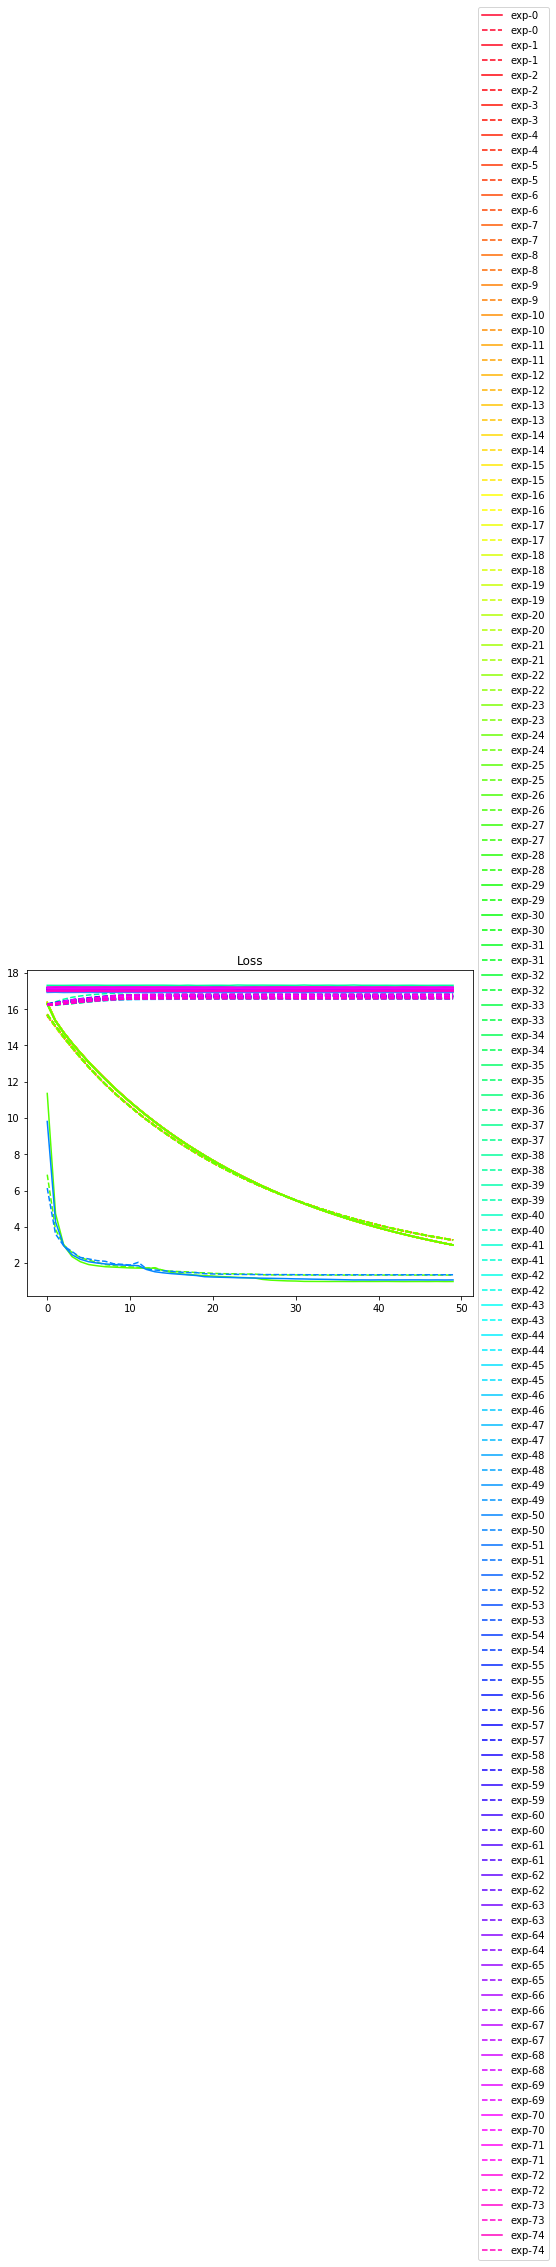

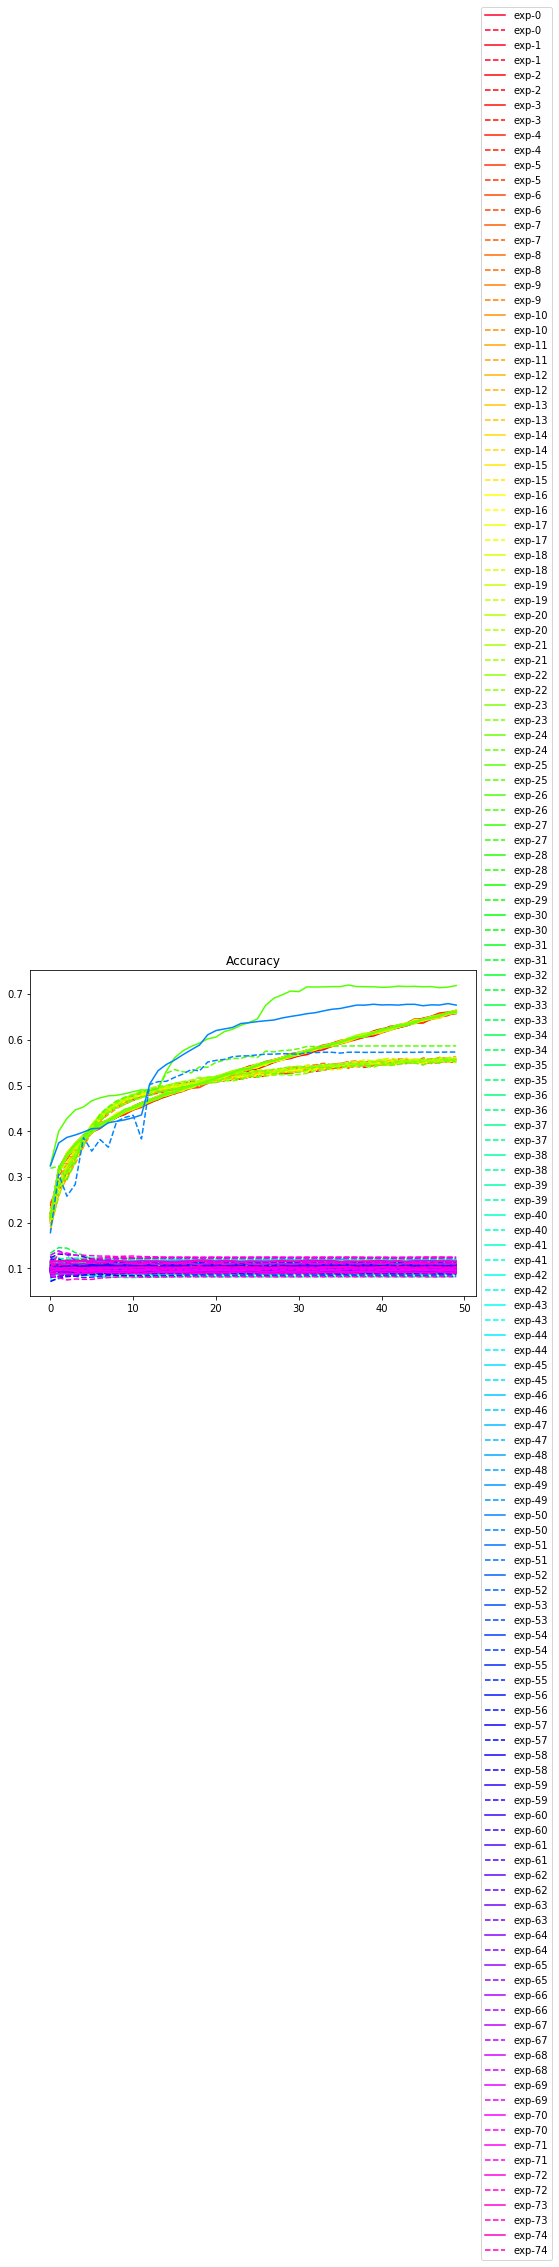

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()